In [43]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");
colors = sns.color_palette()

import warnings

warnings.filterwarnings("ignore", message="X does not have valid feature names")


import urllib.request
import os
def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

# ME 200 - Activity 1 - Introduction to Regression

[Professor Barta](https://engineering.purdue.edu/BartaGroup) and his student Yash Parmar have kindly provided the data for this activity. The data science content is adapted from Professor Bilionis's *Introduction to Data Science* lecture on [linear regression](https://purduemechanicalengineering.github.io/me-239-intro-to-data-science/lecture15/intro.html)

### Question 0: Introduction and data inspection

Surrogate models provide a computationally efficient way to approximate the output of a complex system based on input variables. They are constructed using data from simulations or experiments, enabling rapid predictions without the need for repeated costly evaluations. In this case, we aim to develop surrogate models to predict the compressor’s mass flow rate, $\dot{m}$, and power consumption, $W_{\text{dot}}$, from experimental data given to use by the Barta Group.


In [ ]:
# Import the pandas library
import pandas as pd

# Import the data
data = pd.read_excel('comp_ME200_clean.xlsx')

# Print the first 5 rows of the dataframe
print(data.head())

    T_in      T_out  T_sup    p_in  p_out     m_dot        W_dot   h_in  \
1  20.28  57.051524  10.99  1062.0   2131  0.064510  1809.254295  436.6   
2  15.30  61.810563  10.64   923.5   2122  0.054868  1828.719693  434.6   
3  22.35  73.202209  11.99  1096.0   2765  0.064997  2369.365495  438.0   
4  11.26  67.844000  11.23   798.8   2167  0.046540  1897.510079  433.5   
5  15.81  77.969390  10.91   930.3   2747  0.053854  2399.297200  434.9   

   h_out   s_in  h_out_s  eta_is  T_evap     T_cond  P_evap  P_cond  
1  457.0  1.837    456.6  0.9795    9.29  57.051524  1062.0    2131  
2  463.0  1.843    458.7  0.8499    4.66  61.810563   923.5    2122  
3  466.3  1.839    465.0  0.9533   10.36  73.202209  1096.0    2765  
4  469.3  1.854    462.8  0.8167    0.03  67.844000   798.8    2167  
5  472.7  1.844    466.6  0.8403    4.90  77.969390   930.3    2747  


 We see our headers are in the first row, and our units are in the second row. Let's drop the units row, then we will call the data using the column headers.

In [45]:
# Drop the units row
df = data.iloc[1:]
df = df.apply(pd.to_numeric, errors='coerce')

We have successfully imported our data, see how nicely the pandas dataframe is formatted. We are now going to do something called *feature engineering*. This is where we create new "features" or input variables that are calculated from the measured variables.

We know that $T_{in} - T_{sup}$ gives us the evaporation temperature, $T_{evap}$.

We will assume the following relationships:
+ $T_{out} = T_{cond}$
+ $P_{in} = P_{evap}$
+ $P_{out} = P_{cond}$.

Working in these new variables lets use use our knowledge of thermodynamics to give us intuition about the relationships between the variables.


In [46]:
# Create new columns for the calculated variables
df['T_evap'] = df['T_in'] - df['T_sup']
df['T_cond'] = df['T_out']
df['P_evap'] = df['p_in']
df['P_cond'] = df['p_out']

# Print the first 5 rows of the dataframe
print(df.head())

    T_in      T_out  T_sup    p_in  p_out     m_dot        W_dot   h_in  \
1  20.28  57.051524  10.99  1062.0   2131  0.064510  1809.254295  436.6   
2  15.30  61.810563  10.64   923.5   2122  0.054868  1828.719693  434.6   
3  22.35  73.202209  11.99  1096.0   2765  0.064997  2369.365495  438.0   
4  11.26  67.844000  11.23   798.8   2167  0.046540  1897.510079  433.5   
5  15.81  77.969390  10.91   930.3   2747  0.053854  2399.297200  434.9   

   h_out   s_in  h_out_s  eta_is  T_evap     T_cond  P_evap  P_cond  
1  457.0  1.837    456.6  0.9795    9.29  57.051524  1062.0    2131  
2  463.0  1.843    458.7  0.8499    4.66  61.810563   923.5    2122  
3  466.3  1.839    465.0  0.9533   10.36  73.202209  1096.0    2765  
4  469.3  1.854    462.8  0.8167    0.03  67.844000   798.8    2167  
5  472.7  1.844    466.6  0.8403    4.90  77.969390   930.3    2747  


It is best practice to inspect our data before we start modeling. The Python package Seaborn has a built in function to create a pairwise scatter plot of all the variables in our dataframe. This shows us the relationship between all the variables in our dataframe. For now we will only look at the measured variables, specifically the target variables $m_{\text{dot}}$ and $W_{\text{dot}}$ and the features that we engineered from the measured variables.

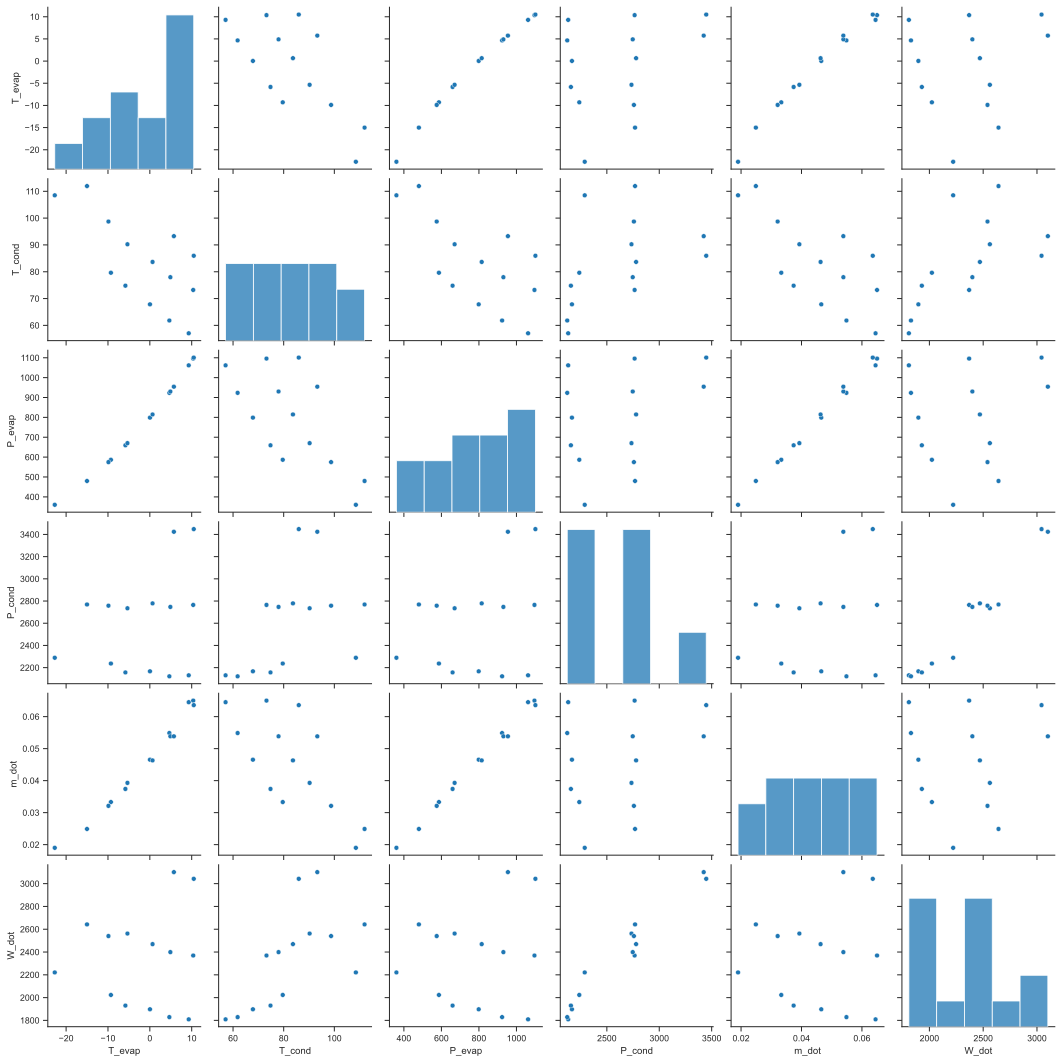

In [47]:
# Split the dataframe in two dataframes, measured and calculated
df_measured = df[['T_evap', 'T_cond', 'P_evap', 'P_cond', 'm_dot', 'W_dot']]
df_calculated = df[['h_in', 'h_out', 's_in', 'h_out_s', 'eta_is']]

# Create a pairwise scatter plot of all the variables
sns.pairplot(df_measured)
plt.show()

### Question 1: Linear model of one variable

Lets make our first model! Let's start with modeling the mass flow rate with just one variable. From inspecting the data, we can see that the mass flow rate is very correlated with the evaporation temperature. This is a good candidate for our first model.

Let's introduce some notation to make our lives easier. We will use **$\mathbf{X}$** to represent our design matrix. The design matrix is a matrix of our input variables, and ones to account for the intercept term, or the "bias" term.

$$
\mathbf{X}  = \begin{bmatrix} 1 & T_{evap,1} \\ 1 & T_{evap,2} \\ \vdots & \vdots \\ 1 & T_{evap,n} \end{bmatrix}
$$

Let's go ahead and create the design matrix for our example.

In [48]:
num_data = len(df)
x = np.array(df['T_evap'])
X = np.hstack((np.ones((num_data, 1)), x.reshape(-1, 1)))
X

array([[  1.   ,   9.29 ],
       [  1.   ,   4.66 ],
       [  1.   ,  10.36 ],
       [  1.   ,   0.03 ],
       [  1.   ,   4.9  ],
       [  1.   ,  10.49 ],
       [  1.   ,  -5.84 ],
       [  1.   ,   0.65 ],
       [  1.   ,   5.74 ],
       [  1.   ,  -9.3  ],
       [  1.   ,  -5.351],
       [  1.   ,  -9.89 ],
       [  1.   , -15.01 ],
       [  1.   , -22.71 ]])



Let's use **$\mathbf{y}$** to represent our target vector.

$$
\mathbf{y} = m_{\text{dot}}
$$

In [49]:
y = np.array(df['m_dot'])



Let's introduce the coefficient of our model as a vector of weights

$$
\mathbf{w} = (w_0, w_1)
$$

We want to find the distance between our predicted value and our target value, we can define this as the euclidean norm

$$
L = ||\mathbf{y} - \mathbf{X}\mathbf{w}||^2
$$

where $\mathbf{X}\mathbf{w}$ is the predicted value of our model given by matrix multiplication.

$$
\mathbf{X}\mathbf{w} = \begin{bmatrix} 1 & T_{evap,1} \\ 1 & T_{evap,2} \\ \vdots & \vdots \\ 1 & T_{evap,n} \end{bmatrix} \begin{bmatrix} w_0 \\ w_1 \end{bmatrix} 
$$

So our distance between the predicted value and the target value is our loss function.

$$
L = ||\mathbf{y} - \mathbf{X}\mathbf{w}||^2 = \sum_{i=1}^{n} (y_i - (w_0 + w_1 x_{i}))^2
$$

We can then take the derivative of this loss function with respect to our weights and set it equal to zero to find the minimum.

$$
\frac{\partial L}{\partial w} = 0
$$

This gives us a linear system that we can solve for our weights. You can see the full derivation in Professor Bilionis's *Introduction to Data Science* lecture [here](https://purduemechanicalengineering.github.io/me-239-intro-to-data-science/lecture15/regression-with-one-variable-revisited.html)

$$
\mathbf{X}^T\mathbf{X}\mathbf{w} = \mathbf{X}^T\mathbf{y}
$$

To solve for the weights, we can use numpy's `linalg.lstsq` function.

In [50]:
w_mdot, _, _, _ = np.linalg.lstsq(X, y, rcond=None)

Take a look at the weights

In [51]:
print(f"w0: {w_mdot[0]:.4f}")
print(f"w1: {w_mdot[1]:.4f}")

w0: 0.0476
w1: 0.0014


We can see how we did by plotting the data and the model.

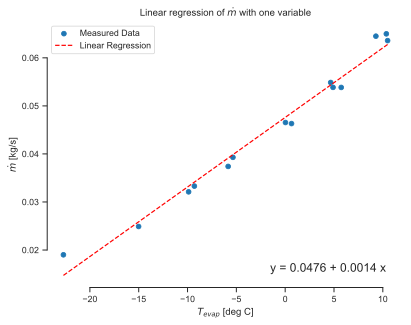

In [52]:
test_T_evap = np.linspace(df['T_evap'].min(), df['T_evap'].max(), 100)
test_X = np.hstack((np.ones((100, 1)), test_T_evap.reshape(-1, 1)))
test_y = test_X @ w_mdot

plt.figure()
plt.scatter(df['T_evap'], df['m_dot'], label='Measured Data')
plt.plot(test_T_evap, test_y, 'r--', label='Linear Regression')
plt.xlabel(r'$T_{evap}$ [deg C]')
plt.ylabel(r'$\dot{m}$ [kg/s]')
plt.title(r'Linear regression of $\dot{m}$ with one variable')
# Plot the equation of the line
plt.text(0.95, 0.05, f'y = {w_mdot[0]:.4f} + {w_mdot[1]:.4f} x', transform=plt.gca().transAxes, fontsize=12, ha='right', va='bottom')
plt.legend()
sns.despine(trim=True)
plt.show()

Now I want you do go ahead and do the same things for the power consumption. Look through the pairwise plots, then create your design matrix and target vector. Then fit your weights with the same method we used for the mass flow rate. Finally, plot the data and the model. Feel free to copy and paste the code from above then tweka it to do this.

In [53]:
# YOUR CODE HERE - take as many cells as you need

w0: -43.9344
w1: 0.9158


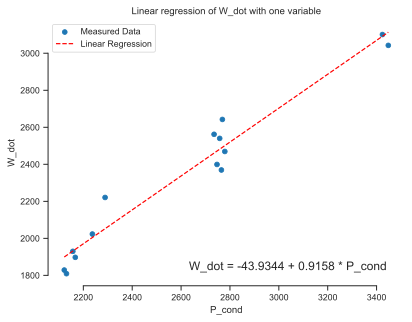

In [54]:
# Define your variable names here – change these strings as needed
input_var = 'P_cond'
target_var = 'W_dot'

# Extract predictor and target data
x = np.array(df[input_var])
num_data = x.shape[0]
X = np.hstack((np.ones((num_data, 1)), x.reshape(-1, 1)))
y = np.array(df[target_var])

# Compute weights using least squares
w_wdot, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
print(f"w0: {w_wdot[0]:.4f}")
print(f"w1: {w_wdot[1]:.4f}")

# Prepare test data for plotting the fitted line
test_x = np.linspace(np.min(x), np.max(x), 100)
test_X = np.hstack((np.ones((100, 1)), test_x.reshape(-1, 1)))
test_y = test_X @ w_wdot

# Plot the measured data and the linear regression fit
plt.figure()
plt.scatter(df[input_var], df[target_var], label='Measured Data')
plt.plot(test_x, test_y, 'r--', label='Linear Regression')
plt.xlabel(input_var)
plt.ylabel(target_var)
plt.title(f'Linear regression of {target_var} with one variable')
plt.text(
    0.95, 0.05, 
    f'{target_var} = {w_wdot[0]:.4f} + {w_wdot[1]:.4f} * {input_var}', 
    transform=plt.gca().transAxes, fontsize=12, ha='right', va='bottom'
)
plt.legend()
sns.despine(trim=True)
plt.show()

As you can see, a linear model of one variable is not a good model for the power consumption. We need a more expressive model. Let's take what we learned about linear models of one variables and extend it to something called generalized linear models.

### Question 2: Generalized linear models

*Generalized linear models* (GLMs) are a class of models that are a generalization of linear models. They are a more flexible class of models that can model more complex relationships between the input and target variables.

The form of the generalized linear model is given by:

$$
y(\mathbf{x}, \mathbf{w}) = \sum_{j=1}^m w_j \phi_j(\mathbf{x}) = \mathbf{w}^T \mathbf{\phi}(\mathbf{x})
$$

where $\mathbf{w}$ is our usual vector of weights, and $\mathbf{\phi}(\mathbf{x})$ is a vector of basis functions. It is linear model because the the model is linear in the weights $\mathbf{w}$, but it does not need to be linear in the input variables $\mathbf{x}$. This can be seen through nonlinear basis functions $\mathbf{\phi}(\mathbf{x})$.

Some examples of nonlinear basis functions are:
+ Polynomial basis functions: $\phi_j(\mathbf{x}) = x_j^2$

+ Fourier basis functions: $\phi_{2j}(\mathbf{x}) = \cos\left(\frac{2j\pi}{L} x_j\right)$ and $\phi_{2j+1}(\mathbf{x}) = \sin\left(\frac{2j\pi}{L} x_j\right)$

+ Radial basis functions: $\phi_j(\mathbf{x}) = \exp(-\frac{||x - c_j||^2}{2\sigma_j^2})$

You can think of choosing your basis function as another way to do feature engineering. Using your engineering knowledge of the problem, you can choose a set of basis functions that are appropriate for the problem. For example if you know that the relationship between the input and target variables is periodic, you can use the Fourier basis functions.

From the Air-Condition, Heating, and Refrigeration Institute (AHRI) [Standard 540](https://www.ahrinet.org/system/files/2023-06/AHRI_Standard_540_%28I-P_and_SI%29_2020_Standard_for_Performance_Rating_of_Positive_Displacement_Refrigerant_Compressors_and_Compressor_Units.pdf), we know that a third-order polynomial is a common model form for mass flow rate and power consumption. 

The input variables are the evaporation temperature, $T_{evap}$, and the condensing temperature, $T_{cond}$.

The features $\phi(\mathbf{x})$ are 
+ The bias term, $\phi_0(\mathbf{x}) = 1$
+ $T_{evap}^n$ for $n = 1, 2, 3$.
+ $T_{cond}^m$ for $m = 1, 2, 3$.
+ $T_{evap}T_{cond}$
+ $T_{evap}^2T_{cond}$
+ $T_{evap}T_{cond}^2$


In our GLM form, we can write the mass flow rate model as:

$$
y(\mathbf{x}, \mathbf{w}) = \sum_{j=0}^{9} w_j \phi_j(\mathbf{x}) 
$$

Or in expanded form:

$$
\dot{m}(\mathbf{x}, \mathbf{w}) = w_0 + w_1 T_{evap} + w_2 T_{cond} + w_3 T_{evap}^2 \\
+ w_4 T_{evap}T_{cond} + w_5 T_{cond}^2 + w_6 T_{evap}^3 + w_7 T_{evap}^2T_{cond}
+ w_8 T_{evap}T_{cond}^2 + w_9 T_{cond}^3
$$

Our design matrix is now defined by the features $\phi(\mathbf{x})$. Let's use sklearn to create our design matrix.

In [55]:
# Import the PolynomialFeatures class from sklearn
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3)
X = poly.fit_transform(df[['T_evap', 'T_cond']])

# print the structure of the design matrix
feature_names = poly.get_feature_names_out()
print(feature_names)


['1' 'T_evap' 'T_cond' 'T_evap^2' 'T_evap T_cond' 'T_cond^2' 'T_evap^3'
 'T_evap^2 T_cond' 'T_evap T_cond^2' 'T_cond^3']


So we can see here that our design matrix has 10 features which correspond to the 10 features we defined earlier. Sklean can do a lot of the heavy lifting for us. We will create the linear model object and then fit it to our target variable.

In [56]:
# Import the LinearRegression class from sklearn
from sklearn.linear_model import LinearRegression
glm_mdot = LinearRegression()

y = df['m_dot']
glm_mdot.fit(X, y)

# Print the model coefficients
print(glm_mdot.coef_)
print(glm_mdot.intercept_)

[ 0.00000000e+00  5.12893487e-02  3.87813117e-02 -7.75927821e-04
 -1.19067541e-03 -4.65072013e-04  5.35117888e-06  9.50744389e-06
  7.01665113e-06  1.83174002e-06]
-1.015856366263988


Visualizing the predctions as a function of the inputs with multiple inputs is a bit more difficult. We can look at the response surface over the input space, but it is more customary to look at a scatter plot of the predictions vs the target variable. This is called a parity plot. A perfect model would have all the points lying on the 1:1 line.

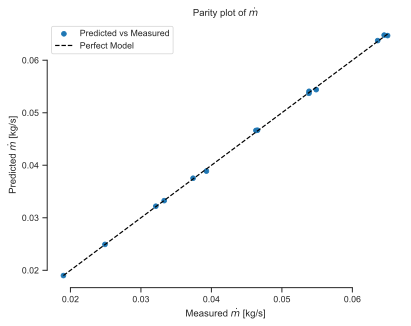

In [57]:
mdot_pred = glm_mdot.predict(X)
perfect_pred = np.linspace(y.min(), y.max(), 100)

plt.figure()
plt.scatter(y, mdot_pred, label='Predicted vs Measured')
plt.plot(perfect_pred, perfect_pred, 'k--', label='Perfect Model')
plt.xlabel(r'Measured $\dot{m}$ [kg/s]')
plt.ylabel(r'Predicted $\dot{m}$ [kg/s]')
plt.title(r'Parity plot of $\dot{m}$')
plt.legend()
sns.despine(trim=True)
plt.show()

Repeat the same steps for the power consumption.

In [58]:
# YOUR CODE HERE

In [59]:
X_wdot = poly.fit_transform(df[['T_evap', 'T_cond']])
y_wdot = df['W_dot']
glm_wdot = LinearRegression()
glm_wdot.fit(X_wdot, y_wdot)
print(glm_wdot.coef_)
print(glm_wdot.intercept_)

[ 0.00000000e+00  3.98367119e+03  3.12328638e+03 -6.56520450e+01
 -9.59741950e+01 -3.72972631e+01  4.23977434e-01  7.90036795e-01
  5.75204237e-01  1.48292077e-01]
-84611.47208357239


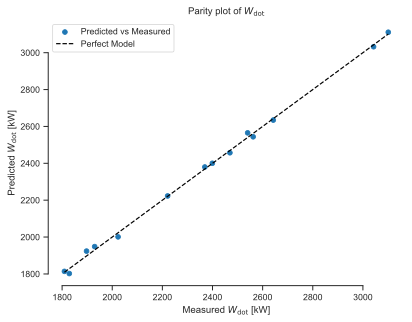

In [60]:

# Make predictions for the generalized linear model
wdot_pred = glm_wdot.predict(X_wdot)

# Create a perfect prediction line
perfect_pred = np.linspace(y_wdot.min(), y_wdot.max(), 100)

# Create a parity plot for the generalized linear model
plt.figure()
plt.scatter(y_wdot, wdot_pred, label='Predicted vs Measured')
plt.plot(perfect_pred, perfect_pred, 'k--', label='Perfect Model')
plt.xlabel(r'Measured $W_{\text{dot}}$ [kW]')
plt.ylabel(r'Predicted $W_{\text{dot}}$ [kW]')
plt.title(r'Parity plot of $W_{\text{dot}}$')
plt.legend()
sns.despine(trim=True)
plt.show()

Now I want you to make a parity plot for the original model you made of $W_{\text{dot}}$ with one variable.

In [61]:
# YOUR CODE HERE

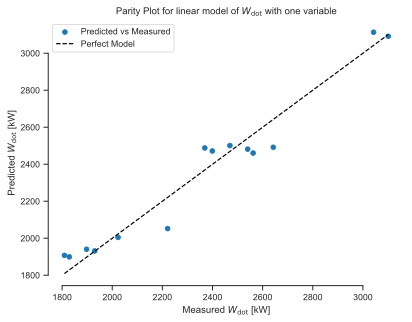

In [62]:
# Make predictions for the linear model of one variable
wdot_pred_linear = w_wdot[0] + w_wdot[1] * df['P_cond']

# Create a parity plot for the linear model of one variable
plt.figure()
plt.scatter(y_wdot, wdot_pred_linear, label='Predicted vs Measured')
plt.plot(perfect_pred, perfect_pred, 'k--', label='Perfect Model')
plt.xlabel(r'Measured $W_{\text{dot}}$ [kW]')
plt.ylabel(r'Predicted $W_{\text{dot}}$ [kW]')
plt.title(r'Parity Plot for linear model of $W_{\text{dot}}$ with one variable')
plt.legend()
sns.despine(trim=True)
plt.show()


We can seee qualitatively that the our generalized linear model is a much better fit for the work consumption model than the linear model of one variable. Visually inspecting the predictions is a perfectly acceptable way to assess model performance, but it can be helpful to have quantative metrics.

### Question 3: Assessing model performance

We can use the mean squared error (MSE) to quantify the performance of our model. The MSE is defined as:

$$
MSE = \frac{1}{N} \sum_{i=1}^{N} (y_i - \mathbf{w}^T \mathbf{\phi}(\mathbf{x}_i))^2
$$

MSE is the squared error between the predicted and measured values. Smaller values of MSE indicate a better fit. Let's write a function to compute the MSE for any model.

In [63]:
# Define a function to compute the MSE
def compute_mse(y, y_pred):
    return 1/len(y) * np.sum((y - y_pred)**2)

I will use the MSE to compare the performance of the linear model of one variable and the generalized linear model for the mass flow rate.

In [64]:
# Compute the MSE for the linear model of one variable
mdot_pred_linear = w_mdot[0] + w_mdot[1] * df['T_evap']
mse_mdot_linear = compute_mse(y, mdot_pred_linear)

# Compute the MSE for the generalized linear model
mdot_pred_glm = glm_mdot.predict(X)
mse_mdot_glm = compute_mse(y, mdot_pred_glm)

# Print the results
print(f"MSE of linear model of one variable: {mse_mdot_linear:.4e}")
print(f"MSE of generalized linear model: {mse_mdot_glm:.4e}")

MSE of linear model of one variable: 3.8929e-06
MSE of generalized linear model: 5.5996e-08


Despite the linear model of one variable performing quite well, the more expressive generalized linear model is a better fit for the data. Differences of such small magnitudes would be difficult to detect visually, but using MSE we can see that the GLM performs better.

Please use the function to calculate the MSE for your two power consumption models.

In [65]:
# YOUR CODE HERE

In [66]:
# Compute the MSE for the linear model of one variable
wdot_pred_linear = w_wdot[0] + w_wdot[1] * df['P_cond']
mse_wdot_linear = compute_mse(y_wdot, wdot_pred_linear)

# Compute the MSE for the generalized linear model
wdot_pred_glm = glm_wdot.predict(X_wdot)
mse_wdot_glm = compute_mse(y_wdot, wdot_pred_glm)

# Print the results
print(f"MSE of linear model of one variable: {mse_wdot_linear:.4e}")
print(f"MSE of generalized linear model: {mse_wdot_glm:.4e}")


MSE of linear model of one variable: 7.6568e+03
MSE of generalized linear model: 2.6804e+02


Once again, we see that the GLM performs better than the linear model of one variable. The MSE for $\dot{W}$ is signifcantly higher than the MSE for the $\dot{m}$ model, but the parity plot does not look that much worse? To compare two models of different kinds, we can use the relative MSE. It is the ratio of the MSE to the MSE of the mean model.

$$
\text{Relative MSE} = \frac{MSE}{MSE_{\hat{\mu}}} = \frac{\sum_{i=1}^{N} (y_i - \mathbf{w}^T \mathbf{\phi}(\mathbf{x}_i))^2}{\sum_{i=1}^{N} (y_i - \hat{\mu})^2}
$$

Make me a function that calculates the relative MSE given measured and predicted values. Then use it to calculate the relative MSE for the two generalized linear models.

In [67]:
# YOUR CODE HERE

In [68]:
# Define a function to compute the Relative MSE
def compute_rel_mse(y, y_pred):
    return compute_mse(y, y_pred) / compute_mse(y, np.mean(y))

# Compute the RMSE for the generalized linear model
rmse_mdot_glm = compute_rel_mse(y, mdot_pred_glm)

# Compute the RMSE for the generalized linear model
rmse_wdot_glm = compute_rel_mse(y_wdot, wdot_pred_glm)

# Print the results
print(f"Relative MSE of m_dot: {rmse_mdot_glm:.4e}")
print(f"Relative MSE of W_dot: {rmse_wdot_glm:.4e}")


Relative MSE of m_dot: 2.7452e-04
Relative MSE of W_dot: 1.6343e-03


The relative MSE is related to a familiar metric, the coefficient of determination, $R^2$.

$$
R^2 = 1 - \frac{MSE}{MSE_{\hat{\mu}}}
$$

Verify that your function of relative MSE and the $R^2$ are equivalent by using the function to calculate the $R^2$ for the two generalized linear models and comparing it to the sklearn r2_score.

In [69]:
# YOUR CODE HERE

In [70]:
# Compute the R^2 for the generalized linear model
r2_mdot_glm = 1 - rmse_mdot_glm
r2_wdot_glm = 1 - rmse_wdot_glm

from sklearn.metrics import r2_score

sklearn_r2_mdot_glm = r2_score(y, mdot_pred_glm)
sklearn_r2_wdot_glm = r2_score(y_wdot, wdot_pred_glm)

# Print the results
print(f"Calculated R^2 of m_dot: {r2_mdot_glm:.4f}")
print(f"sklearn R^2 of m_dot: {sklearn_r2_mdot_glm:.4f}")
print(f"Calculated R^2 of W_dot: {r2_wdot_glm:.4f}")
print(f"sklearn R^2 of W_dot: {sklearn_r2_wdot_glm:.4f}")


Calculated R^2 of m_dot: 0.9997
sklearn R^2 of m_dot: 0.9997
Calculated R^2 of W_dot: 0.9984
sklearn R^2 of W_dot: 0.9984


### Question 4: Using the model

Now that we have a model for the mass flow rate and power consumption, we can use it to predict the outlet enthalpy and efficiency of the compressor at any operating condition. I want you to simple give a point prediction at the given operating condition I give you.

Hint: Do not forget to pass your input variables through the feature mapper.

In [71]:
T_evap_star = 5 # deg C
T_cond_star = 80 # deg C

In [72]:
# YOUR CODE HERE

In [73]:
# Pass the input variables through the feature mapper
input_features = poly.transform(np.array([[T_evap_star, T_cond_star]]))

# Predict the mass flow rate and power consumption
m_dot_star = glm_mdot.predict(input_features)
W_dot_star = glm_wdot.predict(input_features)

# Print the results
print(f"m_dot_star: {m_dot_star[0]:.4f} kg/s")
print(f"W_dot_star: {W_dot_star[0]:.4f} kW")

m_dot_star: 0.0530 kg/s
W_dot_star: 2401.4811 kW


In [77]:
print(data.head(10))

      T_in      T_out    T_sup   p_in  p_out     m_dot        W_dot     h_in  \
0  [deg C]    [deg C]  [deg C]  [kPa]  [kPa]    [kg/s]         [kW]  [kJ/kg]   
1    20.28  57.051524    10.99   1062   2131   0.06451  1809.254295    436.6   
2     15.3  61.810563    10.64  923.5   2122  0.054868  1828.719693    434.6   
3    22.35  73.202209    11.99   1096   2765  0.064997  2369.365495      438   
4    11.26     67.844    11.23  798.8   2167   0.04654  1897.510079    433.5   
5    15.81   77.96939    10.91  930.3   2747  0.053854    2399.2972    434.9   
6     21.5  85.955855    11.01   1101   3448  0.063587  3042.554448      437   
7     4.54  74.792301    10.38  659.6   2157  0.037399  1929.863574    430.3   
8    11.84  83.653114    11.19  814.8   2779  0.046319  2469.383052    433.7   
9    16.65  93.269785    10.91  954.5   3424   0.05384  3101.211445    435.2   

     h_out       s_in  h_out_s  eta_is  
0  [kJ/kg]  [kJ/kg-K]  [kJ/kg]     [-]  
1      457      1.837    456.6  0.979

In [78]:
T_evap_star = 9.29
T_cond_star = 57.05

input_features = poly.transform(np.array([[T_evap_star, T_cond_star]]))

# Use the fixed predictors for prediction
W_dot_star = glm_wdot.predict(input_features)
m_dot_star = glm_mdot.predict(input_features)

# Since predictions are arrays, extract the first element
W_dot_star_val = W_dot_star[0]
m_dot_star_val = m_dot_star[0]

print(f"W_dot_star: {W_dot_star_val:.4f} kW")
print(f"m_dot_star: {m_dot_star_val:.4f} kg/s")

# h_in (from calculated values)
h_in = df_calculated['h_in'].iloc[0]
h_out = df_calculated['h_out'].iloc[0]

# Calculate h_out using energy balance: h_out = h_in + (W_dot / m_dot)
# Note: Ensure units are consistent (e.g., kW = kJ/s so W_dot/m_dot gives kJ/kg)
delta_H = W_dot_star_val / m_dot_star_val
print(f"delta_H: {delta_H:.4f} kJ/kg")

true_delta_H = h_out - h_in
print(f"true_delta_H: {true_delta_H:.4f} kJ/kg")

W_dot_star: 1813.7544 kW
m_dot_star: 0.0648 kg/s
delta_H: 27996.6562 kJ/kg
true_delta_H: 20.4000 kJ/kg
